In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)',
            'Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing data
We'll preparing `X, Y` of `Train, Test` set.

In [2]:
timesteps = 360
print(f'timesteps = {timesteps}')

timesteps = 360


In [3]:
feature_used = features
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)

In [4]:
def prepare_new_test(Train_data, timesteps, feature_used:list):
    path = "../new test/"
    data = {}

    hour_step = timedelta(hours= timesteps-1)
    X = defaultdict(lambda: list())
    Y = defaultdict(lambda: list())

    for province in provinces:
        
        testdf = pd.read_csv(path+f'{province}_new_test.csv', index_col=0, parse_dates=True)[feature_used]
        
        idx = testdf.iloc[:-72].index
        predict_at = idx[idx.hour.isin([6,12,18,0])]
        
        df = Train_data[province].append(testdf)

        for base in predict_at:
            
            i = list(df.index).index(base)

            ## X
            x = df.iloc[i-timesteps+1:i+1]
            
            ## Y
            y = df.iloc[i+1:i+73, [0]]

            X[province].append(x)
            Y[province].append(y)
        print(f"{province} done")

    return data, X, Y

In [5]:
Test_data, X_test, Y_test = prepare_new_test(Train_data, timesteps, feature_used = feature_used)

Bangkok done
Chanthaburi done
Chiang Mai done
Kanchanaburi done
Songkhla done
Khon Kaen done


In [ ]:
X_test['Bangkok'][0]

## Standardize the data


In [6]:
# Scale train set
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)

In [7]:
# Scale test set
X_test_scaled = defaultdict(lambda: [])
Y_test_scaled = defaultdict(lambda: [])

for p in provinces:
    print(p)
    for e in X_test[p]:
        X_test_scaled[p].append(x_train_scalers[p].transform(e))
    for e in Y_test[p]:
        Y_test_scaled[p].append(y_train_scalers[p].transform(e))

Bangkok
Chanthaburi
Chiang Mai
Kanchanaburi
Songkhla
Khon Kaen


## Shaping
Make sure that the data is in the right shape. The `X` shape should be `(#datapoints, #timesteps, #features)`. The `Y` shape should be `(#datapoints, 72)` since each forecast we have to predict next 72 hours.

In [8]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1112, 360, 8)
Y Test: (1112, 72)

Chanthaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1112, 360, 8)
Y Test: (1112, 72)

Chiang Mai
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1112, 360, 8)
Y Test: (1112, 72)

Kanchanaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1112, 360, 8)
Y Test: (1112, 72)

Songkhla
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1127, 360, 8)
Y Test: (1127, 72)

Khon Kaen
X Train: (1936, 360, 8)
Y Train: (1936, 72)
X Test: (1110, 360, 8)
Y Test: (1110, 72)



## Building Model

In [9]:
print(f"timesteps : {timesteps}")

timesteps : 360


In [24]:
province = 'Khon Kaen'
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

# Last check for null values
check = [np.isnan(x_feed).any(), np.isnan(y_feed).any(), 
         np.isnan(x_eval).any(), np.isnan(y_eval).any()]
print(any(check))

False


In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
import tensorflow as tf

n_features = len(feature_used)

# define model
model = Sequential([
    LSTM(100, input_shape=(timesteps, n_features), return_sequences=True),
    Dropout(rate=0.1),
    LSTM(60),
    Dropout(rate=0.1),
    Dense(72, activation='linear')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='mse')

# TensorBoard
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_log_dir = "./my_logs/"+run_id
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                        patience=10, restore_best_weights=True)
# Nan stopping
nan_stop = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(x_feed, y_feed, validation_data=(x_eval, y_eval), 
                    epochs=5, batch_size=32,
                    callbacks=[tensorboard_cb, early_stop, nan_stop])

# tensorboard --logdir=.\my_logs --port=6006

Epoch 1/5
61/61 [==============================] - 48s 721ms/step - loss: 2.9534e-04 - val_loss: 2.6480e-04
Epoch 2/5
61/61 [==============================] - 42s 682ms/step - loss: 2.6169e-04 - val_loss: 2.8190e-04
Epoch 3/5
61/61 [==============================] - 43s 705ms/step - loss: 2.7208e-04 - val_loss: 2.7481e-04
Epoch 4/5
61/61 [==============================] - 40s 659ms/step - loss: 2.6363e-04 - val_loss: 2.6897e-04
Epoch 5/5
61/61 [==============================] - 39s 642ms/step - loss: 2.4556e-04 - val_loss: 2.7843e-04


In [153]:
#model.save(f"./Models/{province}_{run_id}_kind_of_final.h5")

## Evaluate on test data

In [156]:
model.evaluate(x_eval, y_eval)

46/46 [==============================] - 11s 243ms/step - loss: 3.8952e-04


0.00038952179602347314

In [27]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)

for i in range(len(pred)):
    p = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = Y_test[province][i].values
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Khon Kaen


11.9820075520913

province = Khon Kaen


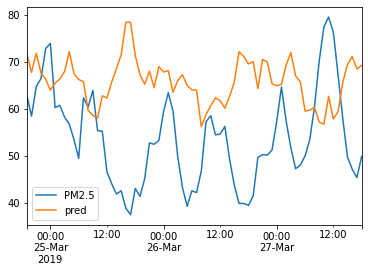

In [33]:
i = 21
print('province =',province)
h = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

In [30]:
np.argmin(rmse)

223

## Save the model
- **Bangkok** : `./Models/Bangkok_run_2021_04_26-13_20_42_final_26Apr.h5` (8.78)
    - all features
    - 360 timesteps
- **Chanthaburi** : `./Models/Chanthaburi_run_2021_04_26-10_42_58_final_26Apr1155.h5` (6.00) 
    - all features
   - 360 timesteps
- **Songkhla** : `./Models/Songkhla_run_2021_04_25-22_41_22.h5` (6.13)
    - all features
    - 360 timesteps 
- **Kanchanaburi** : `./Models/Kanchanaburi_run_2021_04_26-22_18_39_final_26Apr.h5` (10.83)
    - all features
    - 360 timesteps
- **Khon Kaen** : `./Models/Khon Kaen_run_2021_04_27-16_20_46_kind_of_final.h5` (11.24)
    - all features
    - 360 timesteps
- **Chiang Mai** : `./Models/Chiang Mai_run_2021_04_26-19_56_00_final_26Apr.h5` (11.02)

In [19]:
'''
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse

province = "Bangkok"
model = tf.keras.models.load_model("./Models/Chiang Mai_run_2021_04_26-19_56_00_final_26Apr.h5")

x_eval = x_[province]['Test']

pred = model(x_eval)
rmse = []
print('province :', province)

for i in range(len(pred)):
    p = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = Y_test[province][i].values
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)
'''

province : Bangkok


9.142423589170187

# ---

In [21]:
models = {'Bangkok':'./Models/Bangkok_run_2021_04_26-13_20_42_final_26Apr.h5',
'Chanthaburi':'./Models/Chanthaburi_run_2021_04_26-10_42_58_final_26Apr1155.h5',
'Songkhla':'./Models/Songkhla_run_2021_04_25-22_41_22.h5',
'Kanchanaburi':'./Models/Kanchanaburi_run_2021_04_26-22_18_39_final_26Apr.h5',
'Khon Kaen':'./Models/Khon Kaen_run_2021_04_27-16_20_46_kind_of_final.h5',
'Chiang Mai':'./Models/Chiang Mai_run_2021_04_26-19_56_00_final_26Apr.h5'}
grand = []
for province in ["Chanthaburi","Chiang Mai","Kanchanaburi","Bangkok","Khon Kaen","Songkhla"]:
    model = tf.keras.models.load_model(models[province])

    x_eval = x_[province]['Test']

    pred = model(x_eval)

    prediction_1D = []

    for e in pred:
        prediction_1D.append(y_train_scalers[province].inverse_transform(e.numpy().reshape((-1,1))))

    prediction_1D = np.array(prediction_1D).reshape((-1,1))
    province_prediction = pd.DataFrame({'Predicted':prediction_1D.ravel()})

    grand.append(province_prediction)
    print(f"{province} done")

Chanthaburi done
Chiang Mai done
Kanchanaburi done
Bangkok done
Khon Kaen done
Songkhla done


In [23]:
pd.concat(grand, ignore_index=True).rename_axis('Id').to_csv("./predictions/sub2.csv")

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx